In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
META_CSV = "HAM10000/metadata.csv"
df = pd.read_csv(META_CSV)
diagnosis_conversion = pd.read_json('HAM10000/diagnosis_conversion.json', typ='series')
df['diagnosis'] = df['diagnosis_2'].map(diagnosis_conversion)
df.rename(columns=({"isic_id": "image_id"}), inplace=True)

In [3]:
# Add full image path for each row
IMG_DIR = "HAM10000/images/"
df["filepath"] = df["image_id"].apply(lambda x: IMG_DIR + f"{x}.jpg")

In [4]:
print("Class distribution:")
print(df["diagnosis"].value_counts())

Class distribution:
diagnosis
nv       7737
bkl      1338
mel      1305
bcc       622
akiec     378
vasc      180
df        160
Name: count, dtype: int64


In [5]:
label_map = {'akiec':0,'bcc':1,'bkl':2,'df':3,'mel':4,'nv':5,'vasc':6}
df["label"] = df["diagnosis"].map(label_map)

In [6]:
df = df[["image_id", "lesion_id", "diagnosis", "filepath", "label"]]

In [7]:
df.head()

,image_id,lesion_id,diagnosis,filepath,label
0,ISIC_0024306,IL_7252831,nv,HAM10000/images/ISIC_0024306.jpg,5
1,ISIC_0024307,IL_6125741,nv,HAM10000/images/ISIC_0024307.jpg,5
2,ISIC_0024308,IL_3692653,nv,HAM10000/images/ISIC_0024308.jpg,5
3,ISIC_0024309,IL_0959663,nv,HAM10000/images/ISIC_0024309.jpg,5
4,ISIC_0024310,IL_8194852,mel,HAM10000/images/ISIC_0024310.jpg,4


In [8]:
from sklearn.model_selection import GroupShuffleSplit

# Groups = lesion_id (fall back to image_id if any missing)
groups_all = df["lesion_id"].astype(str)
groups_all = groups_all.mask(groups_all.isna() | (groups_all == ""), df["image_id"].astype(str))

gss = GroupShuffleSplit(n_splits=1, test_size=.2, random_state=42)
trainval_idx, test_idx = next(gss.split(df, df["label"], groups_all))

trainval_df = df.iloc[trainval_idx].reset_index(drop=True)
test_df     = df.iloc[test_idx].reset_index(drop=True)

# sanity checks: no leakage
assert set(trainval_df["lesion_id"]).isdisjoint(set(test_df["lesion_id"]))
print("train+val:", len(trainval_df), " | test:", len(test_df))


train+val: 9348  | test: 2372


In [9]:
from sklearn.model_selection import GroupKFold

groups_tv = trainval_df["lesion_id"].astype(str)
groups_tv = groups_tv.mask(groups_tv.isna() | (groups_tv == ""), trainval_df["image_id"].astype(str))

gkf = GroupKFold(n_splits=5)
tr_idx, va_idx = next(gkf.split(trainval_df, trainval_df["label"], groups_tv))

train_df = trainval_df.iloc[tr_idx].reset_index(drop=True)
val_df   = trainval_df.iloc[va_idx].reset_index(drop=True)

# sanity checks: no overlap
assert set(train_df["lesion_id"]).isdisjoint(set(val_df["lesion_id"]))
print("train:", len(train_df), " | val:", len(val_df), " | test:", len(test_df))


train: 7478  | val: 1870  | test: 2372


In [10]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

NUM_CLASSES = 7
classes = np.arange(NUM_CLASSES)

cw = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_df["label"].values
)
class_weights = {int(c): float(w) for c, w in zip(classes, cw)}
class_weights


{0: 4.378220140515222,
 1: 2.7747680890538033,
 2: 1.2523865349187742,
 3: 9.800786369593709,
 4: 1.2153421095400618,
 5: 0.2174406094617778,
 6: 11.245112781954887}

In [ ]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 256
BATCH_SIZE = 32
NUM_CLASSES = 7

def decode_and_resize(path):
    x = tf.io.read_file(path)
    x = tf.image.decode_jpeg(x, channels=3)
    x = tf.image.convert_image_dtype(x, tf.float32)    # [0,1]
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE))
    return x

def map_train(path, y):
    x = decode_and_resize(path)
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, 0.1)
    x = tf.image.random_contrast(x, 0.9, 1.1)
    return x, tf.one_hot(y, depth=NUM_CLASSES)

def map_eval(path, y):
    x = decode_and_resize(path)
    return x, tf.one_hot(y, depth=NUM_CLASSES)

def make_ds(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(len(paths), seed=42, reshuffle_each_iteration=True)
        ds = ds.map(map_train, num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(map_eval,  num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = make_ds(train_df["filepath"].values, train_df["label"].values, training=True)
val_ds   = make_ds(val_df["filepath"].values,   val_df["label"].values,   training=False)
test_ds  = make_ds(test_df["filepath"].values,  test_df["label"].values,  training=False)


2025-11-09 00:25:35.926016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-09 00:25:35.942435: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-09 00:25:35.947892: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1762647937.405734      11 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762647937.412056      11 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have be

In [12]:
def plot_AUC(history):
    plt.figure()
    plt.plot(history.history["auc"], label="train auc")
    plt.plot(history.history["val_auc"], label="val auc")
    plt.legend(); plt.title("AUC"); plt.xlabel("epoch"); plt.ylabel("auc"); plt.show()

In [13]:
from sklearn.metrics import classification_report

target_names=["akiec","bcc","bkl","df","mel","nv","vasc"]

def classification_report_display(y_true, y_pred):
    print(classification_report(
    y_true,
    y_pred,
    target_names=target_names
))

In [14]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_display(y_true, y_pred):
    print(confusion_matrix(y_true, y_pred))

In [15]:
IMG_SIZE = 256
NUM_CLASSES = 7

model_base = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
])

model_base.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(curve="ROC", multi_label=True, num_labels=NUM_CLASSES, name="auc")
    ],
)

cb_base = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=1/3, patience=2, verbose=1),
]

In [16]:
history_base = model_base.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=cb_base,
    verbose=1
)


Epoch 1/30


I0000 00:00:1762647939.888635      62 service.cc:146] XLA service 0x7bdb18009dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762647939.888694      62 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9


  5/234 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - auc: 0.3661 - loss: 1.7485

I0000 00:00:1762647946.376700      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


234/234 ━━━━━━━━━━━━━━━━━━━━ 27s 81ms/step - auc: 0.4986 - loss: 1.9920 - val_auc: 0.6965 - val_loss: 1.8968 - learning_rate: 0.0010
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - auc: 0.6433 - loss: 1.9103 - val_auc: 0.7290 - val_loss: 1.4877 - learning_rate: 0.0010
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - auc: 0.6642 - loss: 1.8013 - val_auc: 0.7175 - val_loss: 1.8403 - learning_rate: 0.0010
Epoch 4/30
233/234 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.6854 - loss: 1.7917
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003333333491658171.
234/234 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - auc: 0.6855 - loss: 1.7919 - val_auc: 0.7526 - val_loss: 1.7036 - learning_rate: 0.0010
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - auc: 0.7057 - loss: 1.8171 - val_auc: 0.7824 - val_loss: 1.5963 - learning_rate: 3.3333e-04
Epoch 6/30
233/234 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.7402 - loss: 1.6637
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.000111

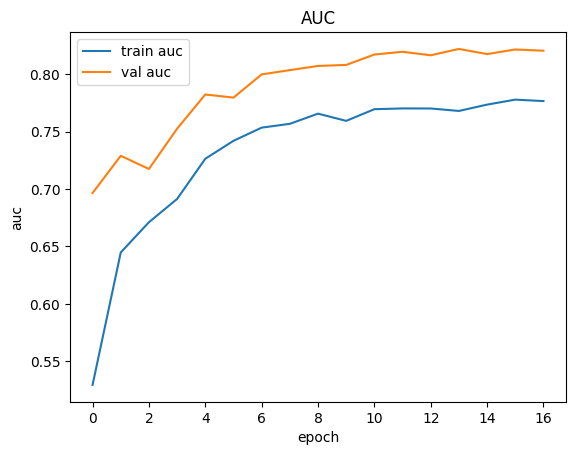

In [17]:
plot_AUC(history_base)

In [18]:
y_true = val_df["label"].values
probs  = model_base.predict(val_ds, verbose=0)
y_pred = probs.argmax(1)

classification_report_display(y_true, y_pred)

confusion_matrix_display(y_true, y_pred)

              precision    recall  f1-score   support

       akiec       0.14      0.37      0.20        67
         bcc       0.23      0.53      0.32       124
         bkl       0.28      0.33      0.30       207
          df       0.06      0.09      0.07        32
         mel       0.27      0.52      0.35       181
          nv       0.96      0.51      0.67      1238
        vasc       0.11      0.48      0.18        21

    accuracy                           0.48      1870
   macro avg       0.29      0.41      0.30      1870
weighted avg       0.72      0.48      0.54      1870

[[ 25  17   7   9   2   5   2]
 [ 24  66   7  17   5   1   4]
 [ 24  66  69  11  28   6   3]
 [  5  16   5   3   0   0   3]
 [  9  27  38   0  94  11   2]
 [ 98  96 120   7 218 630  69]
 [  0   3   1   3   2   2  10]]


In [19]:
base_B0 = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_B0.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base_B0(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
model_B0 = tf.keras.Model(inputs, outputs)

model_B0.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(curve="ROC", multi_label=True, num_labels=NUM_CLASSES, name="auc")
    ],
)

cb_B0 = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=1/3, patience=2, verbose=1),
]

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [20]:
history_B0 = model_B0.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=cb_base,
    verbose=1
)


Epoch 1/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 70s 188ms/step - auc: 0.6543 - loss: 1.8186 - val_auc: 0.8474 - val_loss: 1.3528 - learning_rate: 0.0010
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - auc: 0.8443 - loss: 1.3298 - val_auc: 0.8733 - val_loss: 1.2283 - learning_rate: 0.0010
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - auc: 0.8643 - loss: 1.2919 - val_auc: 0.8806 - val_loss: 1.0710 - learning_rate: 0.0010
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - auc: 0.8721 - loss: 1.2430 - val_auc: 0.8822 - val_loss: 1.2152 - learning_rate: 0.0010
Epoch 5/30
233/234 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.8778 - loss: 1.1884
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003333333491658171.
234/234 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - auc: 0.8778 - loss: 1.1881 - val_auc: 0.8748 - val_loss: 1.2193 - learning_rate: 0.0010
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - auc: 0.8932 - loss: 1.0915 - val_auc: 0.8862 - val_loss: 1.1206 - learning_r

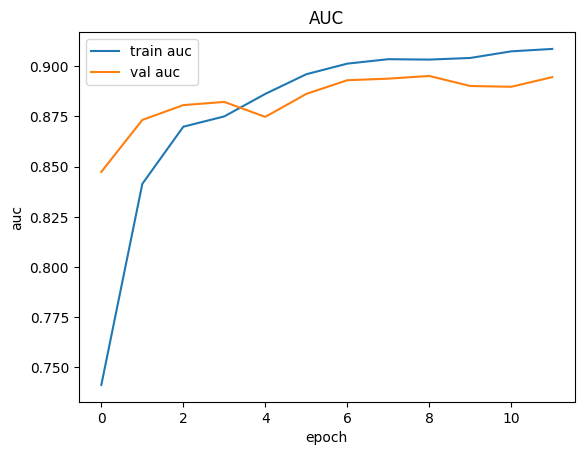

In [21]:
plot_AUC(history_B0)

In [22]:
y_true = val_df["label"].values
probs  = model_B0.predict(val_ds, verbose=0)
y_pred = probs.argmax(1)

classification_report_display(y_true, y_pred)

confusion_matrix_display(y_true, y_pred)

              precision    recall  f1-score   support

       akiec       0.30      0.72      0.42        67
         bcc       0.42      0.56      0.48       124
         bkl       0.47      0.38      0.42       207
          df       0.17      0.44      0.24        32
         mel       0.33      0.51      0.41       181
          nv       0.95      0.74      0.83      1238
        vasc       0.28      0.76      0.41        21

    accuracy                           0.66      1870
   macro avg       0.42      0.59      0.46      1870
weighted avg       0.76      0.66      0.69      1870

[[ 48   6   5   4   2   2   0]
 [ 22  69  11   7   5   6   4]
 [ 31  18  79  16  33  24   6]
 [  8   3   1  14   2   3   1]
 [ 29  12  13   7  93  14  13]
 [ 20  53  58  35 143 912  17]
 [  2   2   0   0   0   1  16]]


In [23]:
# Unfreeze top layers
base_B0.trainable = True
for layer in base_B0.layers[:-30]:
    layer.trainable = False

# Re-compile with a smaller LR
model_B0.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(curve="ROC", multi_label=True, num_labels=NUM_CLASSES, name="auc")
    ],
)


cb_B0 = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, verbose=1),
]

In [24]:
history_B0 = model_B0.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=cb_base,
    verbose=1
)


Epoch 1/30


E0000 00:00:1762648429.294228      62 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762648429.499703      62 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


233/234 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.8337 - loss: 1.3093

E0000 00:00:1762648452.827054      63 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762648453.034554      63 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762648453.233738      63 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


234/234 ━━━━━━━━━━━━━━━━━━━━ 57s 144ms/step - auc: 0.8340 - loss: 1.3081 - val_auc: 0.8952 - val_loss: 1.0542 - learning_rate: 1.0000e-04
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - auc: 0.9112 - loss: 0.9233 - val_auc: 0.9114 - val_loss: 0.9372 - learning_rate: 1.0000e-04
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - auc: 0.9255 - loss: 0.7629 - val_auc: 0.9167 - val_loss: 0.8878 - learning_rate: 1.0000e-04
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - auc: 0.9434 - loss: 0.6467 - val_auc: 0.9200 - val_loss: 0.8779 - learning_rate: 1.0000e-04
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - auc: 0.9525 - loss: 0.5866 - val_auc: 0.9192 - val_loss: 0.8187 - learning_rate: 1.0000e-04
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - auc: 0.9549 - loss: 0.5211 - val_auc: 0.9254 - val_loss: 0.7578 - learning_rate: 1.0000e-04
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - auc: 0.9618 - loss: 0.4823 - val_auc: 0.9294 - val_loss: 0.7544 - 

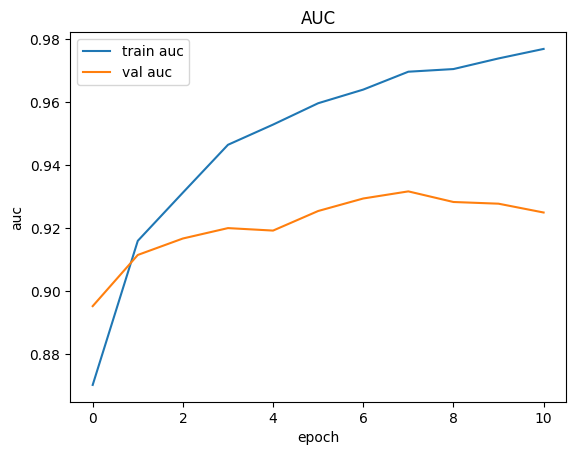

In [25]:
plot_AUC(history_B0)

In [26]:
y_true = val_df["label"].values
probs  = model_B0.predict(val_ds, verbose=0)
y_pred = probs.argmax(1)

classification_report_display(y_true, y_pred)

confusion_matrix_display(y_true, y_pred)

              precision    recall  f1-score   support

       akiec       0.42      0.72      0.53        67
         bcc       0.63      0.77      0.70       124
         bkl       0.55      0.55      0.55       207
          df       0.36      0.47      0.41        32
         mel       0.37      0.65      0.47       181
          nv       0.97      0.78      0.86      1238
        vasc       0.52      0.81      0.63        21

    accuracy                           0.74      1870
   macro avg       0.54      0.68      0.59      1870
weighted avg       0.80      0.74      0.76      1870

[[ 48   7   7   3   1   1   0]
 [  9  96   4   3   8   2   2]
 [ 20   8 113   4  42  17   3]
 [  7   3   2  15   2   2   1]
 [ 15   9  18   2 117  13   7]
 [ 14  25  62  15 149 970   3]
 [  0   4   0   0   0   0  17]]


In [27]:
from sklearn.metrics import precision_recall_curve

probs_val = model_B0.predict(val_ds, verbose=0)  # (N_val, 7)
y_true_val = val_df["label"].values              # (N_val,)
C = NUM_CLASSES
best_thresholds = np.zeros(C, dtype=np.float32)

for c in range(C):
    y_true_c = (y_true_val == c).astype(int)
    prec, rec, thr = precision_recall_curve(y_true_c, probs_val[:, c])
    # f1 has same length as prec/rec; thr has length-1
    f1 = (2 * prec * rec) / (prec + rec + 1e-9)
    # ignore the first point (threshold = +inf, typically all negatives)
    j = np.argmax(f1[1:]) + 1
    best_thresholds[c] = thr[j-1]  # align f1 index to thr index


print(best_thresholds)


[0.5788781  0.46464527 0.335191   0.8416937  0.53438365 0.11706142
 0.9594129 ]


In [28]:
def predict_with_thresholds(probs, thresholds):
    preds = []
    for row in probs:
        # classes that pass their own threshold
        passed = np.where(row >= thresholds)[0]
        if passed.size > 0:
            # pick the passed class with the highest prob
            preds.append(passed[np.argmax(row[passed])])
        else:
            # fallback to argmax if none pass
            preds.append(int(np.argmax(row)))
    return np.array(preds)

# Baseline (argmax) vs Tuned (thresholds)
y_pred_val_argmax = probs_val.argmax(axis=1)
y_pred_val_tuned  = predict_with_thresholds(probs_val, best_thresholds)

classification_report_display(y_true, y_pred_val_tuned)

confusion_matrix_display(y_true, y_pred_val_tuned)


              precision    recall  f1-score   support

       akiec       0.45      0.69      0.54        67
         bcc       0.67      0.77      0.72       124
         bkl       0.53      0.58      0.56       207
          df       0.43      0.38      0.40        32
         mel       0.43      0.57      0.49       181
          nv       0.93      0.83      0.88      1238
        vasc       0.57      0.76      0.65        21

    accuracy                           0.76      1870
   macro avg       0.57      0.65      0.61      1870
weighted avg       0.79      0.76      0.77      1870

[[  46    7    7    3    1    3    0]
 [   8   96    6    3    6    3    2]
 [  16    7  120    3   26   34    1]
 [   7    3    2   12    2    5    1]
 [  13    9   21    1  103   27    7]
 [  12   18   69    6   99 1033    1]
 [   0    4    0    0    0    1   16]]


In [29]:
probs_test = model_B0.predict(test_ds, verbose=0)
y_true_test = test_df["label"].values
y_pred_test = predict_with_thresholds(probs_test, best_thresholds)

classification_report_display(y_true_test, y_pred_test)

confusion_matrix_display(y_true_test, y_pred_test)


              precision    recall  f1-score   support

       akiec       0.39      0.75      0.51        67
         bcc       0.50      0.72      0.59       113
         bkl       0.50      0.53      0.51       278
          df       0.39      0.74      0.51        19
         mel       0.38      0.47      0.42       245
          nv       0.92      0.81      0.87      1586
        vasc       0.80      0.77      0.78        64

    accuracy                           0.74      2372
   macro avg       0.56      0.68      0.60      2372
weighted avg       0.78      0.74      0.75      2372

[[  50    7    4    1    3    1    1]
 [   9   81    6    3    6    4    4]
 [  43   15  146   11   31   32    0]
 [   2    1    0   14    1    1    0]
 [  11    7   52    2  114   57    2]
 [  13   48   81    5  142 1292    5]
 [   0    4    1    0    0   10   49]]


In [ ]:
import json

# 1) Save model
model_B0.save("models/HAM10000_efficientnetB0.keras")  # Keras 3 format

# 2) Save thresholds and metadata
meta = {
    "img_size": 256,
    "class_names": ["akiec","bcc","bkl","df","mel","nv","vasc"],
    "thresholds": [float(x) for x in best_thresholds],  # from the tuned array
    "preprocess": "inputs * 255.0 -> tf.keras.applications.efficientnet.preprocess_input"
}
with open("models/HAM10000_meta.json", "w") as f:
    json.dump(meta, f, indent=2)
